# Jigsaw toxic comments

In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install fastai==1.0.48

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai.text import *
from fastai.callbacks import *
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

## Language model

### Download data

Data below is from kaggle

In [0]:
path = Config.data_path(); path

PosixPath('/root/.fastai/data')

In [0]:
path = '/root/.fastai/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f train.csv

 65% 17.0M/26.3M [00:00<00:00, 71.0MB/s]
100% 26.3M/26.3M [00:00<00:00, 87.7MB/s]


In [0]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f test.csv

 90% 21.0M/23.4M [00:00<00:00, 40.8MB/s]
100% 23.4M/23.4M [00:00<00:00, 52.9MB/s]


In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

In [0]:
train = pd.read_csv('/root/.fastai/data/train.csv')
test = pd.read_csv('/root/.fastai/data/test.csv')
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train.drop(label_cols, 1, inplace=True)

all_df = pd.concat([train, test])
all_df.to_csv('/root/.fastai/data/all.csv', index=False)

In [0]:
all_df.head()

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [0]:
path = Config.data_path()
path.ls()

[PosixPath('/root/.fastai/data/train.csv'),
 PosixPath('/root/.fastai/data/test.csv'),
 PosixPath('/root/.fastai/data/all.csv')]

### Prepare databunch and train LM
The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the review lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs = 32

In [0]:
%%time
# for data from kaggle
np.random.seed(2019)
data_lm = TextLMDataBunch.from_csv(path, 'all.csv', valid_pct=0.1, text_cols=1, 
                                   bs=bs, max_vocab=60000, min_freq=5)

data_lm.save('data_lm.pkl')

CPU times: user 32.2 s, sys: 5.32 s, total: 37.6 s
Wall time: 6min 47s


In [0]:
!mv /root/.fastai/data/data_lm.pkl /content/drive/My\ Drive/DL_projects/toxic_comments

In [0]:
path = Path('/content/drive/My Drive/DL_projects/toxic_comments')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"you write . - · "" xxbos "" \n \n xxmaj first of all , where do you get the idea that one must be an "" "" activist "" "" in order to be pro - choice or to have a pro - choice position on some issue ? xxmaj and where is the article edit where i ever said that xxup xxunk is "" "" activist """
1,"his / her sandboxes to be deleted . xxbos a ! xxmaj xxunk και xxunk [ ] xxbos xxmaj xxunk ( sport ) \n \n xxmaj hello , and welcome to xxmaj wikipedia . xxmaj thanks for writing this article . xxmaj unfortunately it does n't conform to some of xxmaj wikipedia 's guidelines for new articles . xxmaj however , please do not be disheartened by what may"
2,"create links to relevant articles . \n xxmaj per xxmaj wikipedia : xxmaj what is a featured article ? , xxmaj images should have concise captions . \n xxmaj per xxmaj wikipedia : xxmaj manual of xxmaj style ( numbers ) , there should be a non - breaking space - between a number and the unit of measurement . xxmaj for example , instead of"
3,"xxmaj abuja xxmaj hotels with western influences , xxmaj hotels in xxmaj abuja boast of luxury , richness and great hospitality . xxmaj from high - end hotels to budget accommodations , the city has something for everyone . xxmaj comfortable xxunk with live music , huge swimming pools to relax after a tiring day , king - sized beds xxmaj xxunk baths are features of all the luxury hotels"
4,i think this error should be corrected as their is a significant difference between the 2 values stated . \n \n = = xxbos xxmaj put it to bed \n \n xxup sto is not airing xxmaj browns games . \n \n xxmaj how do i know this ? \n \n xxmaj they returned an e - mail i sent them straight up asking them if


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.model_dir = '/content/drive/My Drive/DL_projects/toxic_comments'

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60003, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


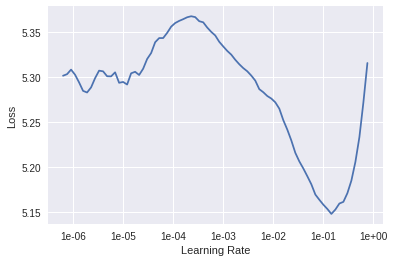

In [0]:
learn.recorder.plot(skip_end=13)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.85,0.75), callbacks=[SaveModelCallback(learn, name='fit_head')])

epoch,train_loss,valid_loss,accuracy,time
0,4.120199,3.917788,0.323485,1:27:16


Better model found at epoch 0 with val_loss value: 3.917788028717041.


In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))  # on google colab with Tesla K80

epoch,train_loss,valid_loss,accuracy,time
0,4.100645,3.904925,0.324353,1:18:09


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


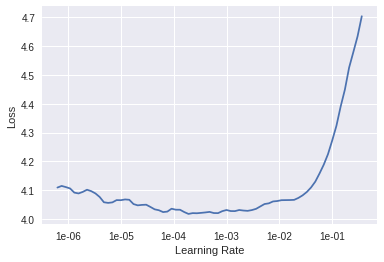

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 1e-3, callbacks=[SaveModelCallback(learn, name='fine_tuned_')])

epoch,train_loss,valid_loss,accuracy,time
0,3.677601,3.660964,0.354539,1:36:57
1,3.644000,3.571490,0.368009,1:36:45
2,3.533014,3.507528,0.376679,1:37:17
3,3.364302,3.464131,0.381898,1:37:15


Better model found at epoch 0 with val_loss value: 3.660963773727417.
Better model found at epoch 1 with val_loss value: 3.5714895725250244.
Better model found at epoch 2 with val_loss value: 3.507528305053711.
Better model found at epoch 3 with val_loss value: 3.4641308784484863.


In [0]:
learn.fit(6, 1e-3, callbacks=[SaveModelCallback(learn, name='fine_tuned')])

epoch,train_loss,valid_loss,accuracy,time
0,3.610816,3.585077,0.365819,1:28:47
1,3.537282,3.523168,0.373000,1:28:24
2,3.501580,3.489014,0.377198,1:28:21
3,3.459861,3.483713,0.378180,1:28:11
4,3.437968,3.464839,0.380223,1:28:22
5,3.373917,3.459369,0.381076,1:28:21


Better model found at epoch 0 with val_loss value: 3.5850768089294434.
Better model found at epoch 1 with val_loss value: 3.5231680870056152.
Better model found at epoch 2 with val_loss value: 3.489014148712158.
Better model found at epoch 3 with val_loss value: 3.483712673187256.
Better model found at epoch 4 with val_loss value: 3.464839220046997.
Better model found at epoch 5 with val_loss value: 3.45936918258667.


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because the God of War is different now . xxbos The link is not considered a copyright violation . If there 's one , then they can be removed . If you have a problem ,
I liked this movie because i removed it from the article . xxbos Doubts about February 15 The Washington Post analysis and your own sources 
  Hi , i 'm sorry to hear that you have deleted Wikipedia


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
bs = 64

In [0]:
# for data from kaggle
train = pd.read_csv('/root/.fastai/data/train.csv')
test = pd.read_csv('/root/.fastai/data/test.csv')

np.random.seed(2019)
msk = np.random.rand(len(train)) < 0.9
valid = train[~msk]
train = train[msk]

In [0]:
train.shape, valid.shape, test.shape

((143720, 8), (15851, 8), (153164, 2))

In [0]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0


In [0]:
path = Path('/content/drive/My Drive/DL_projects/toxic_comments')
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
%%time
# for data from kaggle
data_clas = TextClasDataBunch.from_df(path, train_df=train, valid_df=valid, test_df=test,
                                      vocab=data_lm.vocab, bs=bs,
                                      text_cols='comment_text', label_cols=label_cols)

data_clas.save('data_class.pkl')

CPU times: user 34.6 s, sys: 4.94 s, total: 39.5 s
Wall time: 6min 26s


In [0]:
data_clas = load_data(path, 'data_class.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
xxbos xxup xxunk xxup editing xxup my xxup posts xxup dipshit \n i xxup have a xxup right xxup to xxup state xxup my xxup opinion xxup and i xxup dont xxup give a xxup shit xxup what xxup you xxup consider xxup vandalism xxup you xxup worthless xxup admin xxup power xxup trip xxup piece xxup of xxup shit \n \n xxup stop xxup editing xxup my,toxic
"xxbos "" \n xxrep 23 _ \n \n > xxmaj hello xxmaj beaumont , i noticed that you have recently joined the xxmaj dzierzon discussion and especially xxmaj dzierzon 's self - identification . xxmaj you may want to read his own biography and look at his family photos at [ 56 ] . \n xxmaj what exactly the autobiography is supposed to prove ? xxmaj that",
"xxbos "" \n \n xxmaj matt xxmaj crypto , xxmaj lupo , & xxmaj stormie cover for xxmaj nazism & spam their rants http : / / rexcurry.net / wikipedialies.html \n \n xxmaj there are some regular writers on xxmaj wikipedia who knowingly engage in personal attacks and deletions ( even of links ) of anyone who explains the connection between xxmaj edward xxmaj bellamy and his cousin",
"xxbos "" \n \n xxmaj reply \n xxmaj hi there , since you do not wish to have a united article representing all point of views and would like to stick to your point of view , i have no rights to prevent you other than that of a fellow wikipedian from xxmaj south xxmaj asia . i have divided both the pages under discussion into two parts",


In [0]:
print(data_clas.classes)
data_clas.c, data_clas.loss_func, data_clas.loss_func.func

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


(6, FlattenedLoss of BCEWithLogitsLoss(), BCEWithLogitsLoss())

We can then create a model to classify those comments and load the encoder we saved. Besides, we also want trace model performance during training, so we define some metrics for modeling the dataset. Note we can't use roc_auc/f1 metrics during training owing to the imbalance of dataset (the whole batch targets can be all 0's). We can only trace these after an epoch.

In [0]:
def f1_threshold(y_true, preds):
    best_f1 = 0
    for i in np.arange(0.1, 0.51, 0.01):
        f1 = f1_score(y_true, preds > i)
        if f1 > best_f1:
            threshold = i
            best_f1 = f1
    return best_f1, threshold

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.model_dir = '/content/drive/My Drive/DL_projects/toxic_comments'
learn.metrics = [partial(accuracy_thresh, thresh=0.2)]
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(39631, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(39631, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

### train 1 layer

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


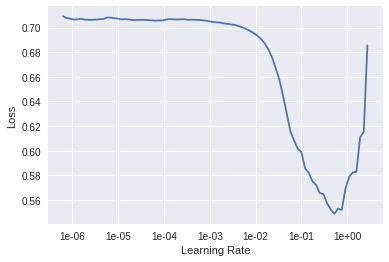

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.066413,0.058771,0.970285,25:31


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
roc_auc_score(y_val, pred_val)

0.975392755711367

In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.730392156862745, 0.34999999999999987),
 (0.4774193548387097, 0.33999999999999986),
 (0.6718192627824018, 0.2799999999999999),
 (0.4225352112676056, 0.21999999999999995),
 (0.6532915360501568, 0.2799999999999999),
 (0.375, 0.24999999999999992)]

In [0]:
learn.fit_one_cycle(3, 2e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.074127,0.122912,0.962126,32:37
1,0.078458,0.071043,0.969886,24:00
2,0.063558,0.060308,0.970738,24:03


In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
print(roc_auc_score(y_val, pred_val))

0.9763239571900146


In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.7203089797232057, 0.2799999999999999),
 (0.4952830188679245, 0.15999999999999998),
 (0.6782296650717702, 0.29999999999999993),
 (0.46938775510204084, 0.13),
 (0.6644649933949802, 0.34999999999999987),
 (0.42105263157894735, 0.18999999999999995)]

In [0]:
learn.fit_one_cycle(4, 2e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.072684,0.063145,0.972178,24:49
1,0.074544,0.062306,0.970107,24:08
2,0.068571,0.057764,0.970233,25:30
3,0.062605,0.057183,0.967583,24:27


In [0]:
learn.save('first_1')

In [0]:
learn.load('first_1');

In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
print(roc_auc_score(y_val, pred_val))

0.9772173256980929


In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.7339449541284403, 0.3999999999999998),
 (0.4988344988344988, 0.21999999999999995),
 (0.6821615339918652, 0.32999999999999985),
 (0.5233644859813085, 0.14999999999999997),
 (0.6666666666666666, 0.3699999999999999),
 (0.43731778425655976, 0.18999999999999995)]

In [0]:
learn.fit_one_cycle(4, 2e-2, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.075716,0.063397,0.961874,16:16
1,0.074198,0.061315,0.964986,16:14
2,0.068132,0.058268,0.965701,15:33
3,0.067919,0.057286,0.968887,16:35


In [0]:
learn.save('first_bsz_64_ech_4')

In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
print(roc_auc_score(y_val, pred_val))

0.9765173024362982


In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.7310539302079662, 0.4299999999999998),
 (0.510385756676558, 0.3199999999999999),
 (0.6867692307692308, 0.3599999999999999),
 (0.5, 0.19999999999999996),
 (0.666231221423906, 0.3899999999999999),
 (0.4452296819787986, 0.21999999999999995)]

### train 2 layers

In [0]:
learn.freeze_to(-2)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


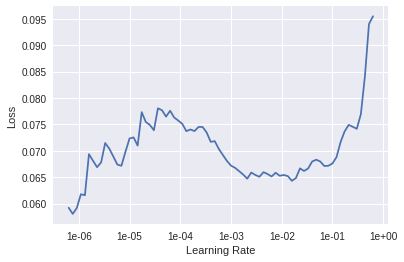

In [0]:
learn.recorder.plot()

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**2),1e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.054172,0.076784,0.975428,18:54
1,0.053256,0.043413,0.977488,20:49


In [0]:
learn.save('second_1')

In [0]:
learn.load('second_1');

In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
roc_auc_score(y_val, pred_val)

0.9874086860124388

In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.8143913920645595, 0.34999999999999987),
 (0.5240384615384616, 0.21999999999999995),
 (0.77602523659306, 0.43999999999999984),
 (0.6097560975609756, 0.4199999999999998),
 (0.7210884353741497, 0.34999999999999987),
 (0.5034965034965034, 0.23999999999999994)]

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.85,0.75))

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
roc_auc_score(y_val, pred_val)

0.9844983947517983

### train 3 layers

In [0]:
learn.freeze_to(-3)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


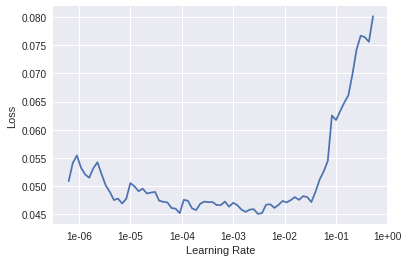

In [0]:
learn.recorder.plot()

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.047025,0.043256,0.976868,29:52
1,0.043294,0.042429,0.978172,31:55


In [0]:
pred_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)
roc_auc_score(y_val, pred_val)

0.9877113335560613

In [0]:
[f1_threshold(y_val[:,i], pred_val[:,i]) for i in range(y_val.size(1))]

[(0.8180277871907828, 0.3999999999999998),
 (0.5352798053527981, 0.19999999999999996),
 (0.7905604719764012, 0.33999999999999986),
 (0.5952380952380952, 0.43999999999999984),
 (0.7295825771324864, 0.32999999999999985),
 (0.5232974910394265, 0.2699999999999999)]

In [0]:
learn.save('third')

In [0]:
learn.load('third');

### train 4 layers

In [0]:
learn.unfreeze()
learn.lr_find()

Min numerical gradient: 6.31E-07


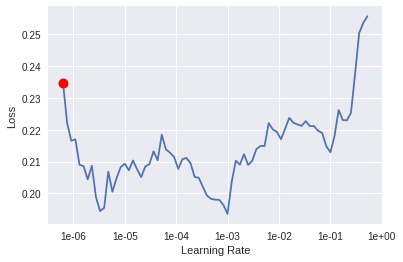

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.85,0.75), callbacks=[SaveModelCallback(learn, name='final-stage')])

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, name='final-stage')])

epoch,train_loss,valid_loss,accuracy
1,0.235903,0.173288,0.928946
2,0.203677,0.165734,0.930561
3,0.197153,0.163580,0.931772
4,0.197304,0.164402,0.930965


In [0]:
learn.save('final-stage')

In [0]:
learn.load('final-stage');

### test time prediction

In [0]:
learn.predict("I really loved that movie, it was awesome!")

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([1.7741e-02, 1.0984e-04, 6.5992e-03, 1.9947e-05, 2.1362e-03, 2.3034e-04]))

In [0]:
learn.predict("You idiot!")

(MultiCategory toxic;obscene;insult,
 tensor([1., 0., 1., 0., 1., 0.]),
 tensor([9.8997e-01, 6.9068e-02, 9.3262e-01, 4.9106e-04, 9.4506e-01, 9.0633e-02]))

In [0]:
# to fix the data ordering problem (for kaggle submission), we add test again
data_clas.add_test(data_clas.test_ds)

In [0]:
%%time
# test set prediction
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 32min 33s, sys: 28min 9s, total: 1h 42s
Wall time: 1h 56s


In [0]:
submit = pd.DataFrame(preds.numpy(), columns=label_cols)
submit['id'] = test['id'].tolist()
submit.to_csv('/content/drive/My Drive/DL_projects/toxic_comments/submit.csv', index=False)

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/toxic_comments')

In [0]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submit.csv -m "awd-lstm trans-learn st-3"

100% 13.8M/13.8M [00:01<00:00, 7.32MB/s]
Successfully submitted to Toxic Comment Classification Challenge